In [1]:
import numpy as np
import pandas as pd
import tqdm

In [2]:
data_dir = '/home/vadim/playlist_generation/data/random_data'

### Загружаем mpd_data(Million playlist dataset)

In [3]:
mpd_data = pd.read_csv('{}/transactions.csv'.format(data_dir), index_col=0)
mpd_data.head()

,userid,trackid
1161,822014,620
1166,822014,1110
1168,822014,1112
1170,822014,1114
1172,822014,683


### Определяем рейтинг единичкой

In [4]:
mpd_data['rating'] = 1
mpd_data.head()

,userid,trackid,rating
1161,822014,620,1
1166,822014,1110,1
1168,822014,1112,1
1170,822014,1114,1
1172,822014,683,1


### Обрежем mpd_data по пользователям для быстроты

In [5]:
data = mpd_data

In [6]:
data.shape

(373089, 3)

In [7]:
from polara.recommender.data import RecommenderData
from polara.recommender.models import SVDModel
from sklearn.model_selection import KFold

In [8]:
def cross_validation_svd(data, n_splits=5, seed=1, test_size=0.05, topk=500, rank=10):
    kf = KFold(n_splits=n_splits, random_state=seed)
    i = 1
    scores = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    for users_ids, unseen_users_ids in kf.split(data['userid'].drop_duplicates()):
        print('=========================Fold {}============================='.format(i))
        i += 1
        users = data['userid'].drop_duplicates().values[users_ids]
        unseen_users = data['userid'].drop_duplicates().values[unseen_users_ids]
        train = data.query('userid in @users')
        test = data.query('userid in @unseen_users')
        test_sampled = test.sample(frac=1-test_size, random_state=seed).sort_values('userid')
        test_holdout = test[~test.index.isin(test_sampled.index)]
        
        data_model = RecommenderData(train,'userid', 'trackid', 'rating', seed=seed)
        data_model.prepare_training_only()
        svd = SVDModel(data_model)
        svd.rank = rank
        svd.build()
        
        data_model.set_test_data(testset=test_sampled, holdout=test_holdout, warm_start=True)
        svd.switch_positive = 1
        svd.topk = topk
        relevance = svd.evaluate('relevance')
        ranking = svd.evaluate('ranking')
        
        scores['precision'].append(relevance.precision)
        scores['recall'].append(relevance.recall)
        scores['miss_rate'].append(relevance.miss_rate)
        scores['nDCG'].append(ranking.nDCG)
        
    result = pd.DataFrame(scores)
    return result

In [9]:
topks = [500]
ranks = [3,4,5,10, 25, 50]
recall = []
nDCG = []
precision = []
miss_rate = []
for rank in tqdm.tqdm(ranks):
    print('             ===========rank={}============='.format(rank))
    print(data.shape)
    result = cross_validation_svd(data, topk=500, test_size=0.1, rank=rank)
    recall.append(result.recall.mean())
    nDCG.append(result.nDCG.mean())
    precision.append(result.precision.mean())
    miss_rate.append(result.miss_rate.mean())

  0%|          | 0/6 [00:00<?, ?it/s]

             ===========rank=3=============
(373089, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.16348437500005275s
1057 unique trackid's within 1145 testset interactions were filtered. Reason: not in the training data.
137 unique trackid's within 140 holdout interactions were filtered. Reason: not in the training data.
30 userid's were filtered out from holdout. Reason: inconsistent with testset.
1253 userid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.13209973400000763s
1027 unique trackid's within 1082 testset interactions were filtered. Reason: not in the training data.
107 unique trackid's within 107 holdout interactions were filtered. Reason: not in the training data.
28 userid's were filtered out from holdout. Reason: inconsistent with testset.
1288 userid's were filtered out fro

 17%|█▋        | 1/6 [00:08<00:41,  8.36s/it]

             ===========rank=4=============
(373089, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.13807001400004992s
1057 unique trackid's within 1145 testset interactions were filtered. Reason: not in the training data.
137 unique trackid's within 140 holdout interactions were filtered. Reason: not in the training data.
30 userid's were filtered out from holdout. Reason: inconsistent with testset.
1253 userid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.1696616440000298s
1027 unique trackid's within 1082 testset interactions were filtered. Reason: not in the training data.
107 unique trackid's within 107 holdout interactions were filtered. Reason: not in the training data.
28 userid's were filtered out from holdout. Reason: inconsistent with testset.
1288 userid's were filtered out from

 33%|███▎      | 2/6 [00:16<00:32,  8.13s/it]

             ===========rank=5=============
(373089, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.253135608999969s
1057 unique trackid's within 1145 testset interactions were filtered. Reason: not in the training data.
137 unique trackid's within 140 holdout interactions were filtered. Reason: not in the training data.
30 userid's were filtered out from holdout. Reason: inconsistent with testset.
1253 userid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.1549714599999561s
1027 unique trackid's within 1082 testset interactions were filtered. Reason: not in the training data.
107 unique trackid's within 107 holdout interactions were filtered. Reason: not in the training data.
28 userid's were filtered out from holdout. Reason: inconsistent with testset.
1288 userid's were filtered out from t

 50%|█████     | 3/6 [00:25<00:25,  8.47s/it]

             ===========rank=10=============
(373089, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.19682629199996882s
1057 unique trackid's within 1145 testset interactions were filtered. Reason: not in the training data.
137 unique trackid's within 140 holdout interactions were filtered. Reason: not in the training data.
30 userid's were filtered out from holdout. Reason: inconsistent with testset.
1253 userid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.18042232000004788s
1027 unique trackid's within 1082 testset interactions were filtered. Reason: not in the training data.
107 unique trackid's within 107 holdout interactions were filtered. Reason: not in the training data.
28 userid's were filtered out from holdout. Reason: inconsistent with testset.
1288 userid's were filtered out fr

 67%|██████▋   | 4/6 [00:34<00:17,  8.67s/it]

             ===========rank=25=============
(373089, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.6607899319999433s
1057 unique trackid's within 1145 testset interactions were filtered. Reason: not in the training data.
137 unique trackid's within 140 holdout interactions were filtered. Reason: not in the training data.
30 userid's were filtered out from holdout. Reason: inconsistent with testset.
1253 userid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.6286811249999573s
1027 unique trackid's within 1082 testset interactions were filtered. Reason: not in the training data.
107 unique trackid's within 107 holdout interactions were filtered. Reason: not in the training data.
28 userid's were filtered out from holdout. Reason: inconsistent with testset.
1288 userid's were filtered out from

 83%|████████▎ | 5/6 [00:45<00:09,  9.14s/it]

             ===========rank=50=============
(373089, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 1.5409900009999546s
1057 unique trackid's within 1145 testset interactions were filtered. Reason: not in the training data.
137 unique trackid's within 140 holdout interactions were filtered. Reason: not in the training data.
30 userid's were filtered out from holdout. Reason: inconsistent with testset.
1253 userid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 2.0736168179998913s
1027 unique trackid's within 1082 testset interactions were filtered. Reason: not in the training data.
107 unique trackid's within 107 holdout interactions were filtered. Reason: not in the training data.
28 userid's were filtered out from holdout. Reason: inconsistent with testset.
1288 userid's were filtered out from

100%|██████████| 6/6 [01:02<00:00, 10.43s/it]


In [10]:
import matplotlib.pyplot as plt

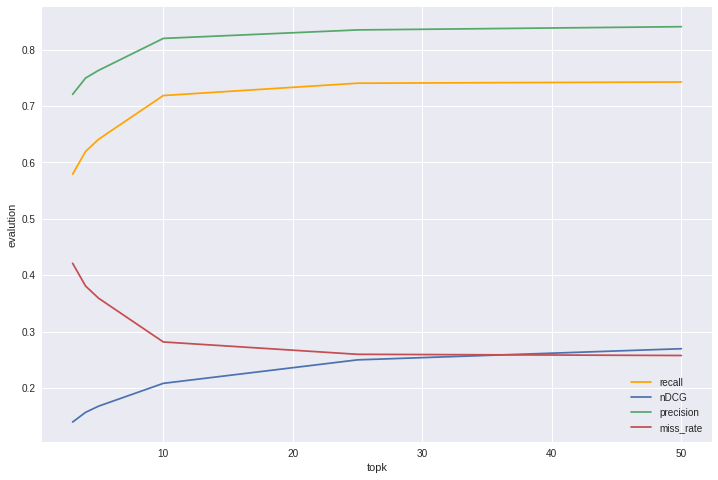

In [11]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(ranks, recall, 'orange', label='recall')
plt.plot(ranks, nDCG,label='nDCG')
plt.plot(ranks, precision, label='precision')
plt.plot(ranks, miss_rate, label='miss_rate')
plt.ylabel('evalution')
plt.xlabel('topk')
plt.legend()
plt.show()